# Copy idp problem files to tias tower

In [ ]:
list_files = ["p12.idp" , "p13.idp" ,  "p16.idp" , "p17.idp" , "p18.idp" , "p19.idp" , "p20.idp" , "p25.idp" , "p5-split.idp", "p93.idp"]
print(len(list_files))


for f in list_files:
    print("scp",f, "tiasTower:/home/emilio/holygrail/idp_files/"+ f)
    
for f in list_files:
    print("scp",f, "tower2:/home/emilio/holygrail/idp_files/"+ f)
    
#for f in list_files:
#    print("idp_exec", f,'grep -v "reduce" >', 'output/'+f+'.output.json')

# Adapt IDP file 

In [ ]:

def Transitivity(num, start):
    
    for i in range(1, num+1):
        print("theory transitivity{} : V {{".format((i-1)*3 +1 ))
        print("\t assumption_satisfied( {}  ) => ! x y z: =>  .".format(start+(i-1)*3 +1))
        print("}")
        print("theory transitivity{} : V {{".format((i-1)*3 +2))
        print("\t assumption_satisfied( {}  ) => ! x y z: => ~ .".format(start+(i-1)*3+2))
        print("}")
        print("theory transitivity{} : V {{".format((i-1)*3 +3))
        print("\t assumption_satisfied( {}  ) => ! x y z: => ~ .".format(start+(i-1)*3+3))
        print("}")
    print("procedure get_trans_theories(){")

    print("\ttransitivity_theories = {")
    for i in range(1, num*3+1):
        print('\t\t{{transitivity{}}}, "Transitivity constraint"}}, '.format(i))
    print("\t}")
    print("\treturn transitivity_theories")
    print("}")

    
def bijectivity(num, start):
    
    for i in range(1, num+1):
        print("theory bijections{} : V {{".format(i))
        print("\t assumption_satisfied( {}  ) => ".format(start+i))
        print("}")
    print("procedure get_bij_theories(){")
    print("\tbijection_theories = {")
    for i in range(1, num+1):
        print('\t\t{{bijections{}}}, "Bijectivity"}}, '.format(i))
    print("\t}")
    print("\treturn	bijection_theories")
    print("}")

In [ ]:
Transitivity(4, 24)
bijectivity(24, 0)

# Input Files preprocessing

Transform the pl files into idp files 


## Setup

Move into the bos/ directory. If you don't want to answers any questions, use the example cachedAnswers.pl provided

cd bos
cp output/cachedAnswers.pl.example output/cachedAnswers.pl

### Run

Be sure to be in the bos/ directory!

To actually run a problem (this will parse everything and try to solve the puzzle as well):

> swipl -g "solvep(problem_name)" -g halt main.pl

To do this for all puzzles:

> swipl -g "solveAll" -g halt main.pl

To just test the parsing of a puzzle:

> swipl -g "testAll([problem_name])" -g halt main.pl

In [394]:
def get_names(plname):
    # get last line of the file, parse to list
    # % name1, name2, ...
    with open(plname, "r") as plfile:
        lines = plfile.read().splitlines()
        lastline = lines[-1]
        if lastline.startswith('%'):
            elems = lastline[2:].split(',')
            return [e.strip() for e in elems]
    return []

def problem_test_name(probname):
    cmd = f'swipl -g "testAll([{probname}])" -g halt main.pl'
    return cmd

def problem_solve_name(probname):
    cmd = f'swipl -g "solvep({probname})" -g halt main.pl'
    return cmd
    
# run BOS on probname, test only
def pl_test(probname):
    cmd = f"swipl -g testAll([{probname}]) -g halt main.pl"

    result = subprocess.run(cmd.split(' '), stdout = subprocess.PIPE)
    out = result.stdout
    if result.returncode != 0:
        print(f"Problem {probname}: [] --> error {result.returncode}")
    if not len(out):
        print(f"Problem {probname}: [] --> no output")
    else:
        lastline = out.splitlines()[-1]
        print(lastline.decode())

plname = "problemsPosterEvaluation.pl"

problem_names = ["p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p25", "p93"]

names = get_names(plname)

for name in problem_names:
    print(problem_solve_name(name))


swipl -g "solvep(p11)" -g halt main.pl
swipl -g "solvep(p12)" -g halt main.pl
swipl -g "solvep(p13)" -g halt main.pl
swipl -g "solvep(p14)" -g halt main.pl
swipl -g "solvep(p15)" -g halt main.pl
swipl -g "solvep(p16)" -g halt main.pl
swipl -g "solvep(p17)" -g halt main.pl
swipl -g "solvep(p18)" -g halt main.pl
swipl -g "solvep(p19)" -g halt main.pl
swipl -g "solvep(p20)" -g halt main.pl
swipl -g "solvep(p25)" -g halt main.pl
swipl -g "solvep(p93)" -g halt main.pl


# Ecai experiments



In [5]:
from pathlib import Path
import json
import sys
import subprocess
from collections import Counter
import matplotlib.pyplot as plt

In [210]:
def ppprint_json(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    print(json.dumps(array, indent=4, sort_keys=True))

In [211]:
def read_print(filename):
    q = Path(filename)
    with q.open() as f: 
        s = f.readlines()
        #print(s)

In [212]:
def json2array(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    return array
        

In [464]:
def costf(assumptions, clue):
    costMapping = {'Transitivity constraint':1,
            'Combination of logigram constriants':2,
            'Bijectivity':1,
                   'clue':1
           }
    
    cost = 0
    
    if clue in costMapping:
        C = costMapping[clue]
    else:
        C = costMapping['clue']
    
    cost += len(assumptions)
    
    if C > 1 or (clue not in costMapping):
        cost +=20
        #cost += 0.01
    
    return cost  

def build_dict(json_array):
    data = {}
    
    data['costs'] = []
    c = []
    data['assumptions'] =  []
    data['derivations'] =  []
    data['time'] = []
    

    clues = []
    
    for row in json_array:
        if('clue' in row):
            clues.append(row['clue'])
        else:
            clues.append(None)
    set_clues = set(clues)
    
    clue_mapping = {}
    clue_cnt = 1
    
    for x in set_clues:
        if 'Transitivity constraint' in x:
            clue_mapping['Transitivity constraint'] = 'Transitivity constraint'
        elif 'Bijectivity' in x:
            clue_mapping['Bijectivity'] = 'Bijectivity'
        elif 'Combination of logigram constriants' in x:
            clue_mapping['Combination of logigram constriants'] = 'Combination of logigram constriants'
        else:
            clue_mapping[x] = 'clue'+str(clue_cnt)
            clue_cnt +=1
    
    for row in json_array:
        if('cost' in row):
            data['costs'].append(costf(row["assumptions"], row['clue']))
        else:
            data['costs'].append(None)

        if('clue' in row):
            c.append(row['clue'])
        else:
            c.append(None)
            
            
        if('assumptions' in row):
            data['assumptions'].append(row["assumptions"])
        else:
            data['assumptions'].append(None)
            
        if('derivations' in row):
            data['derivations'].append(row["derivations"])
        else:
            data['derivations'].append(None)
        if('time' in row):
            data['time'].append(float(row["time"]))
        else:
            data['time'].append(None)
    data['clue'] = []
    for clue in c:
        data['clue'].append(clue)
    
    return data        

In [465]:
def pprint_json(array):
    print(json.dumps(array, indent=4, sort_keys=False))

In [660]:
def count_successive_elems(list_clues):
    counts = []
    count = 1
    for i in range(1,len(list_clues)):
        if list_clues[i-1]==list_clues[i]:
            count+=1
        else :
            counts.append((list_clues[i-1], count))
            count=1
    counts.append((list_clues[i], count))
    return counts

def count_successive_times(list_clues, list_times):
    times = []
    time = list_times[0]
    for i in range(1,len(list_clues)):
        if list_clues[i-1]==list_clues[i]:
            time = list_times[i]
        else :
            times.append((list_clues[i-1], time))
            time = list_times[i]
    times.append((list_clues[i], time))
    return times

def avg(lst): 
    return sum(lst) / len(lst) 

def diffTimes(list_times):
    times = []
    times.append(list_times[0])
    for i in range(1,len(list_times)):
        times.append(list_times[i]-list_times[i-1])
    return times

def clueMeanTimes(list_times, list_clues, list_costs):
    times = diffTimes(list_times)
    d = {}
    trans = []
    bij = []
    clue = []
    csts_trans = []
    csts_bij = []
    csts_clue = []
    for i in range(len(list_clues)-1):
        if list_clues[i] ==  'Transitivity constraint':
            trans.append(times[i])
            csts_trans.append(times[i]/list_costs[i])
        elif list_clues[i] == 'Bijectivity':
            bij.append(times[i])
            csts_bij.append(times[i]/list_costs[i])
        else:
            clue.append(times[i])
            csts_clue.append(times[i]/list_costs[i])
    
    d['avg_trans_time_cst'] = avg(csts_trans)
    d['avg_bij_time_cst'] = avg(csts_bij)
    d['avg_clue_time_cst'] = avg(csts_clue)
    
    d['avg_clue_time'] = avg(clue)
    d['avg_bij_time'] = avg(bij)
    d['avg_trans_time'] = avg(trans)
    
    return d

def total_assumptions(assumptions):
    total = 0
    for i in assumptions:
        total += len(i)
    
    return total

def avg_assumptions(assumptions):
  
    return total_assumptions(assumptions)/len(assumptions)

def avg_clues_assumptions(assumptions, clues):
    tot = total_assumptions(assumptions)
    tot_clues = 0
    clue_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] not in ['Transitivity constraint','Bijectivity','Combination of logigram constriants', 'Solution!']:
            tot_clues += len(v)
            clue_cnt+=1
    return tot_clues/clue_cnt


def avg_bij_assumptions(assumptions, clues):
    tot = total_assumptions(assumptions)
    tot_bij = 0
    bij_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] in ['Bijectivity']:
            tot_bij += len(v)
            bij_cnt += 1
    return tot_bij/bij_cnt

def avg_trans_assumptions(assumptions, clues):
    tot = total_assumptions(assumptions)
    tot_tr = 0
    tr_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] in ['Transitivity constraint']:
            tot_tr += len(v)
            tr_cnt += 1
    return tot_tr/tr_cnt

def clue_0(assumptions, clues):
    tot = 0
    clue_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] not in ['Transitivity constraint','Bijectivity','Combination of logigram constriants', 'Solution!']:
            clue_cnt += 1
            if len(v) == 0:
                tot+=1
    return tot/clue_cnt*100

def clue_1(assumptions, clues):
    tot = 0
    clue_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] not in ['Transitivity constraint','Bijectivity','Combination of logigram constriants', 'Solution!']:
            
            clue_cnt += 1
            if len(v) == 1:
                tot+=1
    return tot/clue_cnt*100



def clue_2(assumptions, clues):
    tot = 0
    clue_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] not in ['Transitivity constraint','Bijectivity','Combination of logigram constriants', 'Solution!']:
            clue_cnt += 1
            if len(v) == 2:
                tot+=1
    return tot/clue_cnt*100

def clue_3(assumptions, clues):
    tot = 0
    clue_cnt = 0
    for i, v in enumerate(assumptions):
        if clues[i] not in ['Transitivity constraint','Bijectivity','Combination of logigram constriants', 'Solution!']:
            clue_cnt += 1
            if len(v) >2:
                tot+=1
    return tot/clue_cnt*100
    
def build_statistics(data_dict):
 
    stats = {}
    
    stats['cost'] = {}
    stats['info'] = {}
    #print(data_dict['time'])
    '''stats['info']['tot_execution_time'] = max(data_dict['time'])
    d = clueMeanTimes(data_dict['time'], data_dict['clue'], data_dict['costs'])
    
    stats['info']['avg_execution_time_clue'] = d['avg_clue_time']
    stats['info']['avg_execution_time_bijectivity'] = d['avg_bij_time']
    stats['info']['avg_execution_time_transitivity'] = d['avg_trans_time']
    
    stats['info']['avg_execution_time_cost_clue'] = d['avg_clue_time_cst']
    stats['info']['avg_execution_time_cost_bijectivity'] = d['avg_bij_time_cst']
    stats['info']['avg_execution_time_cost_transitivity'] = d['avg_trans_time_cst']'''
    stats['info']['reasoning_steps'] = len(data_dict['costs'])
    
    stats['cost']['costs_counter'] =  dict(Counter(data_dict['costs']))
    stats['cost']['total_cost'] = sum([x for x in data_dict['costs'] if x != None])
    stats['cost']['max_cost'] = max([x for x in data_dict['costs'] if x != None])
    stats['cost']['avg_cost'] = stats['cost']['total_cost']/(len([x for x in data_dict['costs'] if x != None]))
    
    sorted_costs = [x for x in data_dict['costs'] if x != None]
    sorted_costs = sorted(sorted_costs)
    sorted_costs.reverse()
    
    stats['cost']['max_scores'] = sorted_costs[0:5]
    
    stats['clues'] = {}
    stats['clues']['clues_counter'] =  dict(Counter(data_dict['clue']))
    stats['clues']['%_explanations_bijectivity'] = round(stats['clues']['clues_counter']['Bijectivity']/(len(data_dict['clue'])-1), 2)*100
    stats['clues']['%_explanations_transitivity'] = round(stats['clues']['clues_counter']['Transitivity constraint']/(len(data_dict['clue'])-1), 2)*100
    stats['clues']['%_explanations_comb'] = 0
    if 'Combination of logigram constraints' in stats['clues']['clues_counter']:
        stats['clues']['%_explanations_comb'] = round(stats['clues']['clues_counter']['Combination of logigram constraints']/(len(data_dict['clue'])-1), 2)*100
    else:
        stats['clues']['clues_counter']['Combination of logigram constraints'] = 0
    stats['clues']['1_clue'] = round((len(data_dict['clue'])-1 - stats['clues']['clues_counter']['Transitivity constraint'] - stats['clues']['clues_counter']['Bijectivity'])/(len(data_dict['clue'])-1), 2)* 100
    stats['clues']['1_clue_trans'] = 0
    stats['clues']['2_clues'] = 0
    stats['clues']['clues_successive_count'] = count_successive_elems(data_dict['clue'])
    '''stats['clues']['successive_times'] = count_successive_times(data_dict['clue'], diffTimes(data_dict['time']))'''
    
    stats['assumptions'] = {}
    stats['assumptions']['avg_assumptions'] = avg_assumptions(data_dict['assumptions'])
    stats['assumptions']['avg_clue_assumptions'] = avg_clues_assumptions(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['avg_bij_assumptions'] = avg_bij_assumptions(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['avg_trans_assumptions'] = avg_trans_assumptions(data_dict['assumptions'], data_dict['clue'])
    
    stats['assumptions']['0 clues'] = clue_0(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['1 clues'] = clue_1(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['2 clues'] = clue_2(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['> clues'] = clue_3(data_dict['assumptions'], data_dict['clue'])
    return stats

In [661]:
def plot_costs(data):
    time = get_time_string()
    costs = []
    for i, v in enumerate(data['costs']):
        if v != None : 
            if data['clue'][i] in ['Transitivity constraint', 'Bijectivity']:
                costs.append(v * -1)
            else:
                costs.append(v)
        else:
            costs.append(0)
    #print(data['costs'])
    #print(data['clue'])
    #print(costs)
    plt.step( [x for x in range(1, len(costs)+1)],costs)
    plt.yticks([x for x in range(min(costs), max(costs)+1, 2) ])
    plt.title('Clue reasoning cost')
    plt.xlabel('Reasoning step number')
    plt.ylabel('Reasoing step cost')
    plt.show()

In [662]:
def costs_histogram(stats):
    time = get_time_string()
    f_stats= {k: v for k, v in stats['cost']['costs_counter'].items() if k is not None}
    #print()
    plt.bar(list(f_stats.keys()), list(f_stats.values()))
    plt.title('Occurences of reasoning step costs')
    plt.xlabel('reasoning step cost')
    plt.ylabel('Occurences')

    plt.show()
    

In [663]:
def successive_clue_bar(stats):
    time = get_time_string()
    fig = plt.figure()
    ax = plt.subplot(111)
    
    succ_counts = stats['clues']['clues_successive_count']
    succ_times = stats['clues']['successive_times']
    
    x1 = [i[0] for i in succ_counts]
    y1 = [i[1] for i in succ_counts]
    y2 = [i[1] for i in succ_times]
        
    ax.step(range(len(y1)), y1)
    ax.step(range(len(y1)), y2)
    plt.title('Successive counts of clue usage')
    plt.xlabel('Clue or reasoning')
    plt.xticks(rotation=90)
    ax.set_xticks(range(len(x1)))
    ax.set_xticklabels(x1)

    plt.ylabel('Times used')
    plt.show()

In [664]:
def plot_exec_time(data):
    time = get_time_string()
    fig = plt.figure()
    instances = ["p12", "p18", "p25"]
    for i in data:
        if i.replace('.output.json', '') in instances:
            times = diffTimes(data[i]['time'])
            plt.plot([x for x in range(0, len(times)+1)],[0] + times, linestyle='--', linewidth=2, markersize=12,label=i.replace('.output.json',''))
    
    #fig.suptitle('Execution time vs step number')
    plt.xlabel('Explanation step')
    plt.ylabel('Execution time in seconds')
    plt.legend(loc='upper right')
    plt.grid(True)
    #fig.savefig('test.jpg')
    fig.set_size_inches(11, 7)
    fig.savefig('/home/crunchmonster/Documents/VUB/Research/NLP/Temp/holygrail/latex/ecai20/figures/plot_exec_time' + '.png',dpi=200, bbox_inches='tight')
    #plt.show()
def plot_cost_steps2(data):
    colors = ["blue","green", "red", "orange"]
    instances = ["p12", "p18", "p25", "nielspasta"]
    idx = 0
    for i in data:
        problem_name=i.replace('.output.json', '')
        if problem_name in instances:
            time = get_time_string()
            fig, ax = plt.subplots()  
            ax.set_yticks(range(0, 5))
            plt.ylim([0, 5])
            
            
            ax.set_yticklabels(['Input', 'Bij.', 'Trans.',  'Clue','m-i'],  fontsize=18)
        #print(data[i])
            locs, labels = plt.yticks()
            plt.setp(labels, rotation=45)
            clues = data[i]['clue']
            # print(clues)
            clues2 = []
            
            for c in clues:
                if 'Bijectivity' in c :
                    clues2.append(1)
                elif 'Transitivity constraint' in c:
                    clues2.append(2)
                elif 'Combination of logigram constraints' in c:
                    clues2.append(4)
                elif 'Solution!' in c:
                    clues2.append(0)
                else:
                    clues2.append(3)
            plt.step([x for x in range(0, len(clues2)+1)] ,[0] + clues2,  linewidth=2, markersize=12, color = colors[idx],label=problem_name)
            idx +=1
            #fig.suptitle('Explanation cost vs step number')
            #plt.ylabel('Explanation type')
            plt.xlabel('Explanation step',  fontsize=18)
            plt.legend(loc='upper right',  fontsize=18)
            plt.grid(True)
            fig.set_size_inches(11, 7)
            plt.savefig('/home/crunchmonster/Documents/VUB/Research/NLP/Temp/holygrail/latex/ecai20/figures/plot_cost_steps_'+problem_name + '.png', dpi=200, bbox_inches='tight')
    
        
    
def plot_cost_steps(data):
    time = get_time_string()
    fig = plt.figure()
    
    instances = ["p12", "p18", "p25"]
    for i in data:
        if i.replace('.output.json', '') in instances:
        #print(data[i])
            costs = data[i]['costs']
            plt.plot([x for x in range(0, len(costs)+1)],[0] + costs, linestyle='--',  linewidth=2, markersize=12, label=i.replace('.output.json',''))
    
    #fig.suptitle('Explanation cost vs step number')
    plt.xlabel('Explanation step')
    plt.ylabel('Execution cost')
    plt.legend(loc='upper left')
    plt.grid(True)
    fig.set_size_inches(11, 7)
    fig.savefig('/home/crunchmonster/Documents/VUB/Research/NLP/Temp/holygrail/latex/ecai20/figures/plot_cost_steps_'+time + '.png', dpi=200, bbox_inches='tight')
    

puzzle & n & $\sum_{i = 1}^{n} c_i$  & max(\textbf{c}) & $\overline{\text{\textbf{c}}}$ & 5 Highest costs & \% bij. & \% trans. & \% comb. & \% clue & \% multiple clues \\ 

In [665]:
def get_time_string():

    import datetime
    now = datetime.datetime.now()
    s = str(now)
    s = s.replace(' ','_')
    s = s.replace(':', '_')
    s = s.replace('-', '_')
    splitted = s.split('.')
    s = splitted[0]
    return s

get_time_string()

'2019_11_20_12_20_23'

In [666]:
'''
dict['filename'] = {costs, clue, assumptions, derivations}

    data = {}
    
    data['costs'] = []
    data['clue'] = []
    data['assumptions'] =  []
    data['derivations'] =  []

    stats['cost'] = {}
    
    stats['cost']['costs_counter']
    stats['cost']['total_cost']
    stats['cost']['avg_cost']
    
    stats['clues'] = {}
    stats['clues']['clues_counter']
    stats['clues']['clues_successive_count']
'''
output_folder = "/home/crunchmonster/Documents/VUB/Research/NLP/holygrail/bos/output"
p = Path('./results')

files = [x for x in p.iterdir() if x.is_file()]
json_file = list(filter(lambda x: 'output.json' in x.name , files) )
#problems = list(filter(lambda x: 'nielspasta' in x.name or 'p5' in x.name , json_file))
file_paths = list(map(lambda f: f.absolute().as_posix(), json_file))
#print(file_paths)

statistics = {}
data = {}

for i, fp in enumerate(file_paths):
    problem_name = json_file[i].name
    json_array = json2array(fp)
    
    data[problem_name] =  build_dict(json_array)
    statistics[problem_name] = build_statistics(data[problem_name])


In [669]:
hline = "\\hline \n"
tabular4 = ""
begin_tabular4 = "\\begin{tabular}{c|cccc|cccccc} \n"
tabular_header4 = "n & $|type|$ & $|dom|$ & $|grid|$ & steps & \% bij & \% trans & \%clue & \%m-i & \%m-c \\\\ \n"
tabular4+= begin_tabular4
tabular4+= tabular_header4
    
for i, fp in enumerate(file_paths):
    
    line4 = ""
    problem_name = json_file[i].name   
    line4 += "{problem_name} & ".format(problem_name=problem_name)

    line4 += "4 & " # type
    line4 += "5 & " # dom
    line4 += "150 & " # grid size
    line4 += "{reasoning_steps} & ".format(reasoning_steps=statistics[problem_name]['info']['reasoning_steps'])
    line4 += "{bij} & ".format(bij=round(statistics[problem_name]['clues']['clues_counter']['Bijectivity']/statistics[problem_name]['info']['reasoning_steps']*100,2))
    line4 += "{tr} & ".format(tr=round(statistics[problem_name]['clues']['clues_counter']['Transitivity constraint']/statistics[problem_name]['info']['reasoning_steps']*100,2))
    line4 += "{cl} & ".format(cl=round((len(data[problem_name]['clue'])-1 - statistics[problem_name]['clues']['clues_counter']['Transitivity constraint'] - statistics[problem_name]['clues']['clues_counter']['Bijectivity'] - statistics[problem_name]['clues']['clues_counter']['Combination of logigram constraints'])/statistics[problem_name]['info']['reasoning_steps']*100,2))
    line4 += "{c} & ".format(c=round(statistics[problem_name]['clues']['clues_counter']['Combination of logigram constraints']/statistics[problem_name]['info']['reasoning_steps']*100,2))
    line4 += "0"
    line4 += "\\\\ \n"
    tabular4 += hline
    tabular4 += line4
                            
tabular4 += end_tabular

print(tabular4)

\begin{tabular}{c|cccc|cccccc} 
n & $|type|$ & $|dom|$ & $|grid|$ & steps & \% bij & \% trans & \%clue & \%m-i & \%m-c \\ 
\hline 
p5.output.json & 4 & 5 & 150 & 113 & 30.97 & 49.56 & 18.58 & 0.0 & 0\\ 
\hline 
p16.output.json & 4 & 5 & 150 & 122 & 21.31 & 59.02 & 18.85 & 0.0 & 0\\ 
\hline 
p93.output.json & 4 & 5 & 150 & 119 & 33.61 & 47.06 & 18.49 & 0.0 & 0\\ 
\hline 
p12.output.json & 4 & 5 & 150 & 115 & 28.7 & 53.91 & 16.52 & 0.0 & 0\\ 
\hline 
p18.output.json & 4 & 5 & 150 & 116 & 27.59 & 54.31 & 17.24 & 0.0 & 0\\ 
\hline 
p20.output.json & 4 & 5 & 150 & 116 & 26.72 & 57.76 & 14.66 & 0.0 & 0\\ 
\hline 
nielspasta.output.json & 4 & 5 & 150 & 82 & 34.15 & 40.24 & 21.95 & 2.44 & 0\\ 
\hline 
p25.output.json & 4 & 5 & 150 & 111 & 36.94 & 45.05 & 17.12 & 0.0 & 0\\ 
\hline 
p19.output.json & 4 & 5 & 150 & 123 & 24.39 & 58.54 & 16.26 & 0.0 & 0\\ 
\end{tabular} 


In [668]:
hline = "\\hline \n"
tabular3 = ""
begin_tabular3 = "\\begin{tabular}{l|c|ccc|cccc}  \n"
tabular_header3 = "& \\multicolumn{4}{c|}{avg. facts} & \\multicolumn{4}{c}{\\% of clue expl. with facts} \\\\ \\textbf{p} & \\textbf{all} & \\textbf{Bij.} & \\textbf{Trans.} & \\textbf{Clues} & \\textbf{0 facts} & \\textbf{1 fact} & \\textbf{2 facts} & \\textbf{$>$2 facts}\\\\ \n"
tabular3+= begin_tabular3
tabular3+= tabular_header3
    
for i, fp in enumerate(file_paths):
    
    line3 = ""
    problem_name = json_file[i].name
    
    line3 += "{problem_name} & ".format(problem_name=problem_name.replace('.output.json', ''))
    line3 += "{a} & ".format(a=round(statistics[problem_name]['assumptions']['avg_assumptions'], 3))
    line3 += "{a} & ".format(a=round(statistics[problem_name]['assumptions']['avg_clue_assumptions'], 3))
    line3 += "{a} & ".format(a=round(statistics[problem_name]['assumptions']['avg_trans_assumptions'], 3))
    line3 += "{a} &".format(a=round(statistics[problem_name]['assumptions']['avg_bij_assumptions'], 3))
    line3 += "{a}\\% &".format(a=round(statistics[problem_name]['assumptions']['0 clues'], 2))
    line3 += "{a}\\% &".format(a=round(statistics[problem_name]['assumptions']['1 clues'], 2))
    line3 += "{a}\\% &".format(a=round(statistics[problem_name]['assumptions']['2 clues'], 2))
    line3 += "{a}\\% ".format(a=round(statistics[problem_name]['assumptions']['> clues'], 2))
    line3 += "\\\\ \n"
    tabular3 += hline
    tabular3 += line3
                            
tabular3 += end_tabular

print(tabular3)

\begin{tabular}{l|c|ccc|cccc}  
& \multicolumn{4}{c|}{avg. facts} & \multicolumn{4}{c}{\% of clue expl. with facts} \\ \textbf{p} & \textbf{all} & \textbf{Bij.} & \textbf{Trans.} & \textbf{Clues} & \textbf{0 facts} & \textbf{1 fact} & \textbf{2 facts} & \textbf{$>$2 facts}\\ 
\hline 
p5 & 1.823 & 0.524 & 2.0 & 2.371 &66.67\% &28.57\% &0.0\% &4.76\% \\ 
\hline 
p16 & 1.803 & 0.609 & 2.0 & 2.385 &47.83\% &47.83\% &0.0\% &4.35\% \\ 
\hline 
p93 & 1.84 & 0.182 & 2.0 & 2.575 &81.82\% &18.18\% &0.0\% &0.0\% \\ 
\hline 
p12 & 1.835 & 0.316 & 2.0 & 2.455 &78.95\% &15.79\% &0.0\% &5.26\% \\ 
\hline 
p18 & 1.853 & 0.45 & 2.0 & 2.5 &70.0\% &15.0\% &15.0\% &0.0\% \\ 
\hline 
p20 & 1.828 & 0.294 & 2.0 & 2.355 &76.47\% &17.65\% &5.88\% &0.0\% \\ 
\hline 
nielspasta & 1.768 & 1.05 & 2.0 & 2.071 &60.0\% &15.0\% &0.0\% &25.0\% \\ 
\hline 
p25 & 1.937 & 0.737 & 2.0 & 2.463 &57.89\% &26.32\% &5.26\% &10.53\% \\ 
\hline 
p19 & 1.87 & 0.4 & 2.0 & 2.6 &65.0\% &30.0\% &5.0\% &0.0\% \\ 
\end{tabular} 


In [647]:
    stats['assumptions']['0 clues'] = clue_0(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['1 clues'] = clue_1(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['2 clues'] = clue_2(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['> clues']

NameError: name 'data_dict' is not defined

In [648]:
    stats['assumptions']['avg_assumptions'] = avg_assumptions(data_dict['assumptions'])
    stats['assumptions']['avg_clue_assumptions'] = avg_clues_assumptions(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['avg_bij_assumptions'] = avg_bij_assumptions(data_dict['assumptions'], data_dict['clue'])
    stats['assumptions']['avg_trans_assumptions'] = avg_trans_assumptions(data_dict['assumptions'], data_dict['clue'])

NameError: name 'data_dict' is not defined

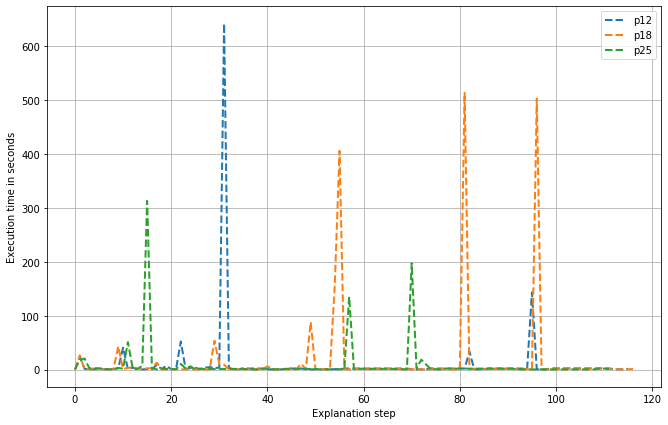

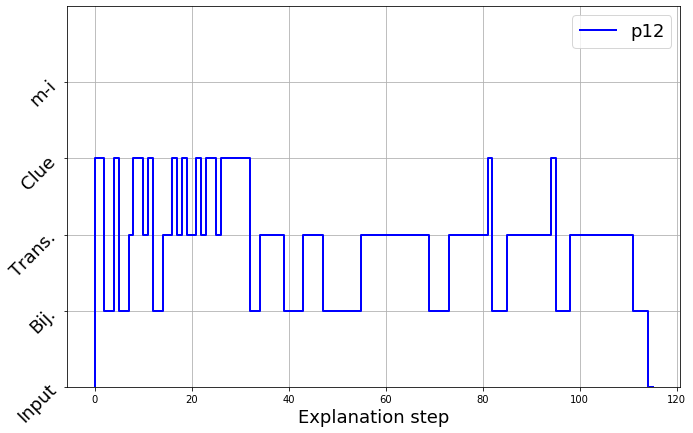

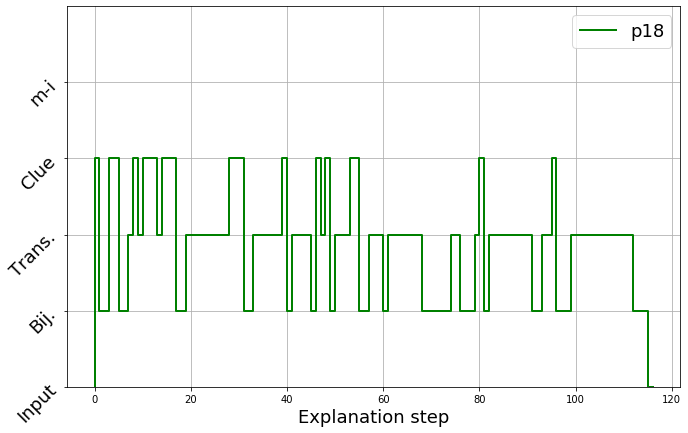

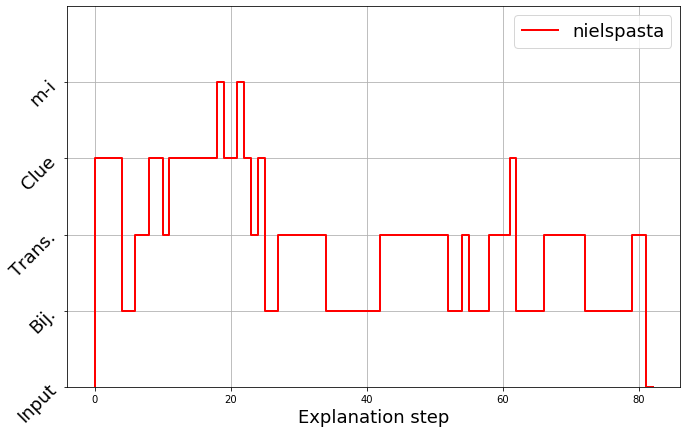

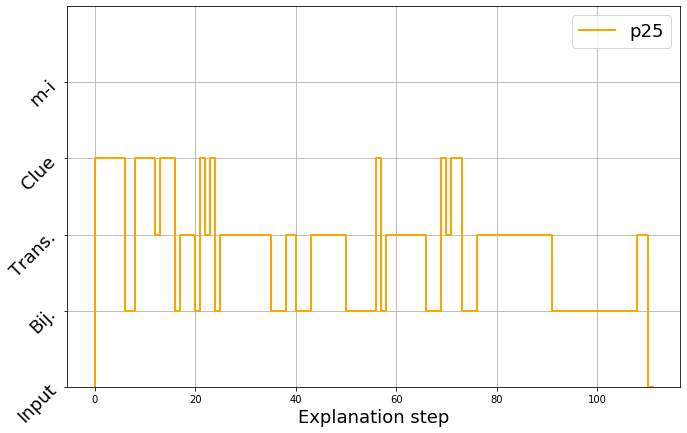

In [616]:
'''
tabular = ""
begin_tabular = "\\begin{tabular}{|l||c|c|c|c|c||c|c|c|c|c|c|} \n"
hline = "\\hline \n"
tabular_header = "\\textbf{puzzle} & \\textbf{n} & $\\sum_{i = 1}^{n} c_i$  & max(\\textbf{c}) & $\\overline{\\text{\\textbf{c}}}$ & 5 Highest costs & \\% bij. & \\% trans. & \\% comb. & \\% clue & \\% multiple clues \\\\ \n"
end_tabular = "\\end{tabular} "

tabular += begin_tabular
tabular += hline
tabular += tabular_header
tabular += hline

for i, fp in enumerate(file_paths):
    problem_name = json_file[i].name
    
    line = ""
    
    line += "{problem_name} & ".format(problem_name=problem_name)  
    line += "{reasoning_steps} & ".format(reasoning_steps=statistics[problem_name]['info']['reasoning_steps'])
    line += "{totalcost} & ".format(totalcost=statistics[problem_name]['cost']['total_cost'])
    line += "{max_score} & ".format(max_score=statistics[problem_name]['cost']['max_cost'])
    line += "{avg_score} & ".format(avg_score=round(statistics[problem_name]['cost']['avg_cost'], 2))
    line += "{max_scores} & ".format(max_scores=statistics[problem_name]['cost']['max_scores'])
    
    line += "{bij} & ".format(bij=round(statistics[problem_name]['clues']['%_explanations_bijectivity'], 0))
    line += "{tr} & ".format(tr=round(statistics[problem_name]['clues']['%_explanations_transitivity'] , 0))
    line += "{comb} & ".format(comb=round(statistics[problem_name]['clues']['%_explanations_comb'], 0))
    line += "{clue1} & ".format(clue1=statistics[problem_name]['clues']['1_clue'])
    line += "{clue2} \\\\ \n".format(clue2=statistics[problem_name]['clues']['2_clues'] )
    
    #print(line)
    tabular += line
    tabular += hline

tabular2 = ""
begin_tabular2 = "\\begin{tabular}{|l||c|c|c|c|c|c|c|} \n"
tabular_header2 = "\\textbf{puzzle} & \\textbf{tot exec time} & avg clue time  & avg bij. & avg trans. & avg time/cost of clue & avg time/cost of bij. & avg time/cost of bij. \\\\ \n"
tabular2+= begin_tabular2
tabular2+= tabular_header2
    
for i, fp in enumerate(file_paths):
    
    line2 = ""
    problem_name = json_file[i].name   
    
    line2 += "{problem_name} & ".format(problem_name=problem_name)
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['tot_execution_time'], 0))
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['avg_execution_time_clue'], 2))
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['avg_execution_time_bijectivity'], 2))
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['avg_execution_time_transitivity'], 2))
    
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['avg_execution_time_cost_clue'] , 2))
    line2 += "{a} & ".format(a=round(statistics[problem_name]['info']['avg_execution_time_cost_bijectivity']  , 2))

    line2 += "{a} \\\\ \n ".format(a=round(statistics[problem_name]['info']['avg_execution_time_cost_transitivity'] , 2))
    tabular2 += hline
    tabular2 += line2
                            
tabular2 += end_tabular'''
'''
print(tabular)
    
print(tabular2)'''

#print(sequence_output)    
#print(explanation_output)

#pprint_json(statistics['nielspasta.output.json'])

#costs_histogram(statistics['p12.output.json'])
#successive_clue_bar(statistics['p12.output.json'])
#plot_costs(data['p12.output.json'])

plot_exec_time(data)
plot_cost_steps2(data)
#print(statistics['nielspasta.output.json']['clues']['clues_counter'])
#pprint_json(data['nielspasta.output.json'])

In [609]:
cH6GR7hD9UYn3LW

NameError: name 'cH6GR7hD9UYn3LW' is not defined